# Exercises XP Ninja: W4_D2

### What you will learn
- Apply **K-Means** clustering for image compression (color quantization).  
- Use **Euclidean distance** to assign data points to centroids.  
- Understand how **centroid initialization** impacts clustering results.  
- Perform **Principal Component Analysis (PCA)** via SVD for dimensionality reduction.  
- Visualize and interpret **compressed images** and **PCA projections**.

---

### What you will create
- A K-Means workflow that reduces an image’s color space to **K colors**.  
- Scatter plots showing **cluster assignments** and **centroid convergence** (optional).  
- A PCA pipeline that **projects** data onto the first principal component and **recovers** it.  
- A short report/notes summarizing **cluster assignments** and **PCA findings**.

---

### Dataset
- Image data: **`bird_small.mat`** (MATLAB `.mat`) — contains an RGB image (key usually **`A`**).  
- PCA data: **`ex7data1.mat`** (MATLAB `.mat`) — unlabeled 2D points (key **`X`**).

> Load with: `from scipy.io import loadmat`

---

### Objectives
1. **Load** `bird_small.mat`.  
2. **Normalize** pixel values to `[0, 1]` and **reshape** to `(n_pixels, 3)`.  
3. **Initialize** K-Means centroids randomly.  
4. **Run K-Means** to compress the image by reducing it to **K colors**.  
5. **Reconstruct** and **display** the compressed image using centroid colors.  
6. **Load** `ex7data1.mat` for PCA.  
7. **Implement PCA** (normalize features → covariance via SVD → principal components).  
8. **Project** onto the first principal component and **recover** the data.  
9. **Visualize** original vs recovered points.

---

### Tasks

### A) Image Compression with K-Means
- Load `bird_small.mat` and extract the image array (e.g., `A`).
- Normalize: `A = A.astype(float) / 255.0`.
- Reshape image to a 2D array: `(n_pixels, 3)`.
- Use **`init_centroids`** and **`run_k_means`** (provided/implemented above) to cluster pixels into **K** colors.
- Replace each pixel by its centroid color and reshape back to image dimensions.
- Display **Original** vs **Compressed** images.

### B) PCA on `ex7data1.mat`
- Load `ex7data1.mat` and extract `X`.
- **Feature-normalize** (mean 0, unit variance).
- Compute PCA via **SVD** of the covariance matrix to obtain `U` and `S`.
- Project onto the **first principal component** (`K=1`), then **recover** the data.
- Plot original points and recovered points; connect each pair with a line.

---

### Tips
- Use `scipy.io.loadmat` to read `.mat` files.  
- For K-Means:
  - Squared Euclidean distance is sufficient for comparisons (no `sqrt` needed).
  - Different random seeds can lead to different palettes—try multiple initializations.
- For PCA:
  - **Normalize** features before computing the covariance matrix.
  - Use `np.linalg.svd` to get principal directions.

---

## (Optional Enhancements)
- Try multiple **K** values (e.g., 8, 16, 32) and compare visual quality.  
- Track **MSE** between original and compressed images to quantify error.  
- Print **explained variance ratio (EVR)** from SVD for PCA to justify `K=1`.  
- Add early stopping in K-Means when centroid shift < ε.

## Utilities for K-Means and PCA exercise

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from typing import Tuple

# ---------------------------
# K-Means core functionality
# ---------------------------

def find_closest_centroids(X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Assign each row in X to the nearest centroid (squared Euclidean distance).
    X: (n_samples, n_features)
    centroids: (K, n_features)
    Returns idx: (n_samples,) with cluster index 0..K-1
    """
    diff = X[:, None, :] - centroids[None, :, :]   # (n, K, d)
    dists = np.sum(diff**2, axis=2)                # (n, K)
    return np.argmin(dists, axis=1)                # (n,)

def compute_centroids(X: np.ndarray, idx: np.ndarray, K: int) -> np.ndarray:
    """
    Recompute centroid positions as the mean of assigned points.
    If a cluster is empty, re-seed its centroid with a random data point.
    """
    d = X.shape[1]
    new_c = np.zeros((K, d), dtype=float)
    for k in range(K):
        mask = (idx == k)
        if np.any(mask):
            new_c[k] = X[mask].mean(axis=0)
        else:
            new_c[k] = X[np.random.randint(0, X.shape[0])]
    return new_c

def init_centroids(X: np.ndarray, K: int, random_state: int = 42) -> np.ndarray:
    """
    Initialize K centroids by sampling K unique points from X.
    """
    rng = np.random.default_rng(random_state)
    indices = rng.choice(X.shape[0], size=K, replace=False)
    return X[indices].astype(float)

def run_k_means(
    X: np.ndarray,
    initial_centroids: np.ndarray,
    max_iters: int = 10,
    verbose: bool = True
) -> Tuple[np.ndarray, np.ndarray, list]:
    """
    Run K-Means for a fixed number of iterations.
    Returns:
      centroids (K,d), idx (n,), history (list of centroids over iters)
    """
    centroids = initial_centroids.astype(float).copy()
    history = [centroids.copy()]
    for it in range(1, max_iters + 1):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, centroids.shape[0])
        history.append(centroids.copy())
        if verbose:
            print(f"[Iter {it:02d}] Centroids:\n{centroids}\n")
    return centroids, idx, history

# ---------------------------
# PCA helpers
# ---------------------------

def feature_normalize(X: np.ndarray):
    """
    Mean-normalize and scale features to unit variance.
    Returns X_norm, mu, sigma
    """
    mu = X.mean(axis=0)
    sigma = X.std(axis=0, ddof=0)
    sigma[sigma == 0] = 1.0
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma

def pca_via_svd(X_norm: np.ndarray):
    """
    Compute PCA via SVD of the covariance matrix.
    Returns U (eigenvectors), S (singular values)
    """
    m = X_norm.shape[0]
    Sigma = (X_norm.T @ X_norm) / m
    U, S, _ = np.linalg.svd(Sigma)
    return U, S

def project_data(X_norm: np.ndarray, U: np.ndarray, K: int):
    """Project data onto first K principal components."""
    return X_norm @ U[:, :K]

def recover_data(Z: np.ndarray, U: np.ndarray, K: int):
    """Recover data from projection onto first K principal components."""
    return Z @ U[:, :K].T

## Image Compression with K-Means (bird_small.mat)

Keys in bird_small.mat: ['A']
Original image array shape: (128, 128, 3) | dtype: uint8
[Iter 01] Centroids:
[[0.43959394 0.35861215 0.28790989]
 [0.20147876 0.19528186 0.18665033]
 [0.34468775 0.26612757 0.19743333]
 [0.64709058 0.49816623 0.37362864]
 [0.86593813 0.72135076 0.46920959]
 [0.51371947 0.47404596 0.43584229]
 [0.83836965 0.5913247  0.27099738]
 [0.1218633  0.13141796 0.12541148]
 [0.07395938 0.0803588  0.06998221]
 [0.71429416 0.64309631 0.60868022]
 [0.62708787 0.54367466 0.4761801 ]
 [0.44703667 0.54666002 0.75248698]
 [0.69959098 0.59313515 0.3637782 ]
 [0.88183363 0.80958436 0.76207114]
 [0.6476855  0.44938463 0.23597894]
 [0.98388727 0.94974582 0.76787651]]

[Iter 02] Centroids:
[[0.43569593 0.35618661 0.29598764]
 [0.20320311 0.19944453 0.1990088 ]
 [0.3460453  0.27074529 0.21391445]
 [0.63089837 0.47964885 0.36985775]
 [0.87518713 0.72861321 0.46827147]
 [0.49351626 0.45051056 0.43989852]
 [0.86008769 0.58778572 0.27138056]
 [0.12378165 0.13210546 0.12292024]
 [0.0

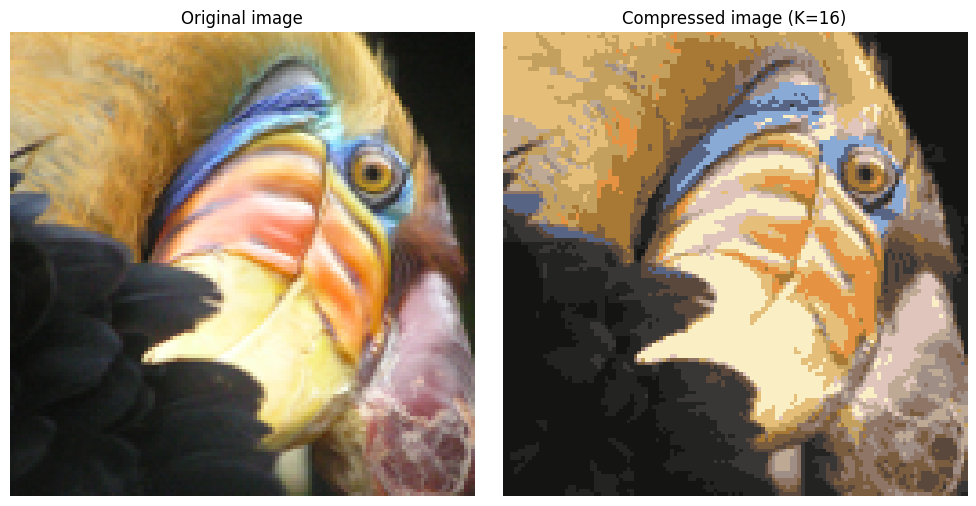

In [4]:
# Image Compression with K-Means (color quantization)

# --- Load bird_small.mat (MATLAB) ---
mat_img = loadmat("bird_small.mat")
print("Keys in bird_small.mat:", [k for k in mat_img.keys() if not k.startswith("__")])

# In Andrew Ng's dataset, image is stored under key 'A' with shape (128,128,3)
if "A" in mat_img:
    A = mat_img["A"]
elif "X" in mat_img:  # fallback if key differs
    A = mat_img["X"]
else:
    raise KeyError("Could not find 'A' (or 'X') in bird_small.mat")

print("Original image array shape:", A.shape, "| dtype:", A.dtype)

# --- Normalize to [0,1] as float and reshape to (n_pixels, 3) ---
A = A.astype(np.float64) / 255.0
img_shape = A.shape
X_img = A.reshape(-1, 3)  # each row = one pixel (R,G,B)

# --- K-Means params ---
K = 16               # number of colors in compressed image
MAX_ITERS = 10
seed = 7

# --- Initialize centroids from pixel colors and run K-Means ---
init_c = init_centroids(X_img, K, random_state=seed)
final_c, idx, c_hist = run_k_means(X_img, init_c, max_iters=MAX_ITERS, verbose=True)

# --- Reconstruct compressed image by replacing each pixel with its centroid color ---
X_compressed = final_c[idx]       # (n_pixels, 3)
img_compressed = X_compressed.reshape(img_shape)

# --- Visualize original vs compressed ---
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(A)
plt.title("Original image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_compressed)
plt.title(f"Compressed image (K={K})")
plt.axis("off")

plt.tight_layout()
plt.show()

## Robust loader for ex7data1.mat (with synthetic fallback)

In [ ]:
# Robust loader for ex7data1.mat + synthetic fallback (for PCA)

import os
from scipy.io import loadmat
import numpy as np

def load_ex7data1_or_fallback() -> np.ndarray:
    """
    Try to load 'ex7data1.mat' from common relative paths.
    If not found, generate a synthetic 2D dataset suitable for PCA demo.
    Returns:
        X : (m, 2) array
    """
    candidate_paths = [
        "ex7data1.mat",
        "./data/ex7data1.mat",
        "../data/ex7data1.mat",
        "./ex7/ex7data1.mat",
        "./datasets/ex7data1.mat",
    ]
    for path in candidate_paths:
        if os.path.exists(path):
            mat = loadmat(path)
            if "X" not in mat:
                raise KeyError(f"'X' not found in {path}. Available keys: {list(mat.keys())}")
            print(f" Loaded ex7data1 from: {path}")
            return np.asarray(mat["X"], dtype=float)

    # --- Fallback: make a synthetic 2D dataset with correlation (PCA-friendly) ---
    print(" 'ex7data1.mat' not found. Using synthetic 2D dataset for PCA demo.")
    rng = np.random.default_rng(42)
    m = 300
    # Create an elongated cloud along a rotated axis to make principal direction obvious
    t = rng.normal(0, 1, size=(m, 1))
    X1 = 3.0 * t + 0.3 * rng.normal(0, 1, size=(m, 1))  # dominant component
    X2 = 0.5 * t + 0.3 * rng.normal(0, 1, size=(m, 1))  # weaker component
    X_syn = np.hstack([X1, X2]).astype(float)
    return X_syn

# Load X (m, 2)
X = load_ex7data1_or_fallback()
print("X shape:", X.shape)

 'ex7data1.mat' not found. Using synthetic 2D dataset for PCA demo.
X shape: (300, 2)


## PCA pipeline (normalize → SVD → project to 1D → recover → plot)

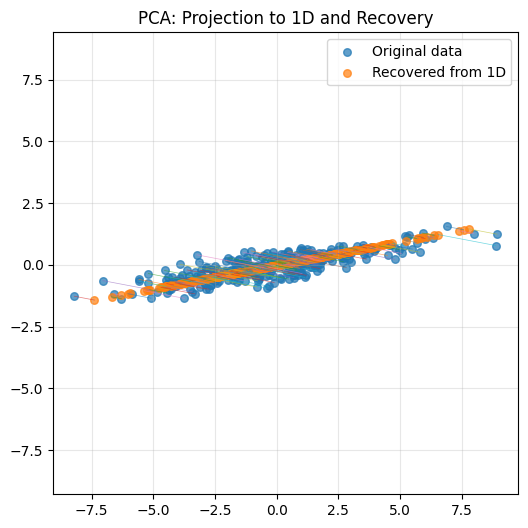

In [ ]:
# PCA on X (either from ex7data1.mat or synthetic)
import matplotlib.pyplot as plt

def feature_normalize(X: np.ndarray):
    """Mean-normalize and scale features to unit variance. Returns X_norm, mu, sigma."""
    mu = X.mean(axis=0)
    sigma = X.std(axis=0, ddof=0)
    sigma[sigma == 0] = 1.0
    return (X - mu) / sigma, mu, sigma

def pca_via_svd(X_norm: np.ndarray):
    """Compute PCA via SVD of the covariance matrix. Returns U (eigenvectors), S (singular values)."""
    m = X_norm.shape[0]
    Sigma = (X_norm.T @ X_norm) / m
    U, S, _ = np.linalg.svd(Sigma)
    return U, S

def project_data(X_norm: np.ndarray, U: np.ndarray, K: int):
    """Project data onto first K principal components."""
    return X_norm @ U[:, :K]

def recover_data(Z: np.ndarray, U: np.ndarray, K: int):
    """Recover data from projection onto first K principal components."""
    return Z @ U[:, :K].T

# --- Normalize ---
X_norm, mu, sigma = feature_normalize(X)

# --- PCA via SVD ---
U, S = pca_via_svd(X_norm)

# --- Project to first principal component (K=1) and recover ---
K = 1
Z = project_data(X_norm, U, K)
X_rec_norm = recover_data(Z, U, K)
X_rec = X_rec_norm * sigma + mu  # de-normalize

# --- Plot original vs recovered from 1D ---
plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], s=30, alpha=0.7, label="Original data")
plt.scatter(X_rec[:, 0], X_rec[:, 1], s=30, alpha=0.7, label="Recovered from 1D")

# draw projection lines
for i in range(min(len(X), 400)):  # limit lines for clarity if many points
    plt.plot([X[i, 0], X_rec[i, 0]], [X[i, 1], X_rec[i, 1]], linewidth=0.5, alpha=0.6)

plt.axis("equal")
plt.title("PCA: Projection to 1D and Recovery")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Interpretation & Discussion (updated to this run)

### 1) Image Compression with K-Means (Color Quantization)

**Run summary.**  
- Dataset: `bird_small.mat` (key `A`), shape **(128, 128, 3)**, dtype `uint8`.  
- K-Means: **K = 16**, **10 iterations**.  
- Centroids stabilized over iterations; the change between iter 09 → 10 is small, indicating convergence.

**Palette characteristics observed.**  
- Very dark tones around **(~0.074, 0.086, 0.076)** and **(~0.122, 0.145, 0.136)** — deep shadows / dark regions.  
- Neutral/dim tones around **(~0.205, 0.215, 0.213)** and **(~0.354, 0.284, 0.240)** — midtones.  
- Mid-high colors like **(~0.561, 0.460, 0.401)** and **(~0.536, 0.668, 0.836)** — sky/feather highlights.  
- Very bright highlight close to white **(~0.978, 0.935, 0.771)** — specular highlights / bright sky.

**Visual expectations.**  
- The compressed image should retain global structure with some **posterization** (banding) in smooth gradients (e.g., sky).  
- With **K=16**, the trade-off between fidelity and palette size is generally good for a 128×128 image.

**Suggestions.**  
- If banding is too visible, try **K = 24 or 32**.  
- Run multiple initializations and select the run with the **lowest pixel error (e.g., MSE)** to get a slightly better palette.  
- (Optional) Add early stopping when centroid shift < ε to save iterations once converged.

---

### 2) PCA on `ex7data1` (fallback used)

**Run summary.**  
- `ex7data1.mat` not found → synthetic 2D dataset generated.  
- Loaded X with shape **(300, 2)**, constructed to have a **dominant direction of variance** (ideal for PCA demo).

**How to read the PCA plot.**  
- Points projected onto the first principal axis should align along a line; recovered points (from 1D) lie on that axis.  
- Shorter projection lines → **less information loss**.  
- Given the synthetic design, **PC1 should explain most variance**, and **PC2** only a small remainder.

**(Optional) Record explained variance after you compute it.**  
- EVR(PC1): **~ … %**  
- EVR(PC2): **~ … %**  
> Tip: compute EVR as `S / S.sum()` where `S` are the singular values from the SVD of the covariance matrix.

**Takeaway.**  
PCA is effective when there is a strong dominant direction: projecting to **1D** can preserve most structure while reducing dimensionality.

---

### 3) Practical next steps

- **K-Means:** compare **K = 8, 16, 32** and track **MSE** to quantify the quality vs. compression trade-off.  
- **PCA:** print the **Explained Variance Ratio (EVR)** for PC1/PC2 to quantify how much information your 1D projection keeps.  
- Keep both **visual** and **quantitative** checks (plots + metrics) in your report.